In [787]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.metrics import silhouette_score

data = pd.read_csv('../data/df_model.csv')
df = pd.DataFrame(data)
df.head()

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 578 entries, 0 to 577
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   administración              578 non-null    int64  
 1   estrato                     578 non-null    int64  
 2   antiguedad                  578 non-null    int64  
 3   área                        578 non-null    float64
 4   habitaciones                578 non-null    int64  
 5   baños                       578 non-null    int64  
 6   garajes                     578 non-null    int64  
 7   elevadores                  578 non-null    int64  
 8   tipo_de_inmueble            578 non-null    object 
 9   porteria                    578 non-null    object 
 10  precio                      578 non-null    float64
 11  Localidad                   578 non-null    object 
 12  Tasa_Homicidios_100k        578 non-null    float64
 13  Tasa_Hurtos_100k            578 non

#### Nuestras caracteristicas seran variables que estan altamente correlacionadas entre si, como el area y la cantidad de garajes, y para evitar overfitting utilizamos una variable que no esta tan relacionada con el precio ni con el área, que será la tasa de hurtos.

In [788]:
FEATURES = df[['log_precio','área','Tasa_Hurtos_100k','garajes']]
#Estandarizacion de las caracteristicas seleccionadas
scaler = StandardScaler()
X = FEATURES
X_scaled = scaler.fit_transform(X)

#### Nos quedamos con el 95% de la informacion de nuestro dataset principal

In [789]:
#Reduccion de dimensionalidad con PCA
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)

#Varianza explicada
explained_var = pca.explained_variance_ratio_
cumulative_var = np.cumsum(explained_var)
cumulative_var


array([0.63660102, 0.88714509, 0.96224755])

## PRE CLUSTERING CON MiniBatchKMeans PARA UNA AGRUPACION INICIAL RAPIDA

<function matplotlib.pyplot.show(close=None, block=None)>

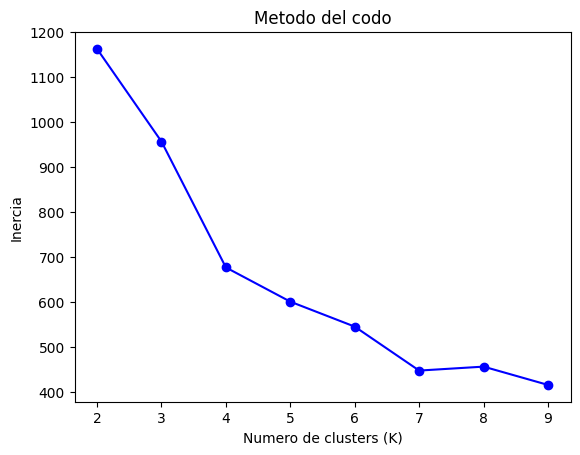

In [790]:
inertias = []
for k in range(2,10):
    model = MiniBatchKMeans(n_clusters=k, random_state=42)
    model.fit(X_scaled)
    inertias.append(model.inertia_)

plt.plot(range(2,10), inertias, 'bo-')
plt.xlabel('Numero de clusters (K)')
plt.ylabel('Inercia')
plt.title('Metodo del codo')
plt.show

### Notamos que el numero total de clusters ideal serian 3, en este caso (nivel de lujo bajo, medio y alto)

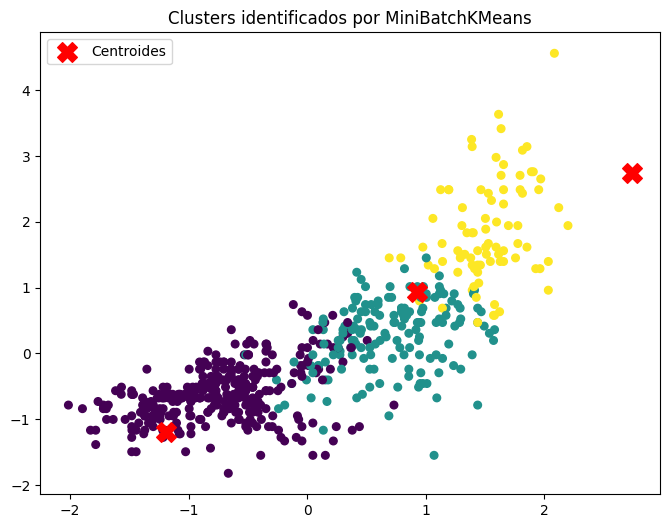

In [791]:
mini_kmeans = MiniBatchKMeans(n_clusters=3, random_state=42, batch_size=50)
pre_labels = mini_kmeans.fit_predict(X_pca)

plt.figure(figsize=(8,6))
plt.scatter(X_scaled[:,0], X_scaled[:,1], c=mini_kmeans.labels_, cmap='viridis', s=30)
plt.scatter(mini_kmeans.cluster_centers_[:,0],
            mini_kmeans.cluster_centers_[:,0],
            c='red', marker='X', s=200, label='Centroides')  # 🔹 el 'X' va entre comillas
plt.title("Clusters identificados por MiniBatchKMeans")
plt.legend()
plt.show()

### Obtenemos clusters bien separados, el modelo diferencia bastante bien los grupos y los clasifica segun el nivel de lujo.

In [792]:
score = silhouette_score(X_scaled, mini_kmeans.labels_)
print("Coeficiente de Silueta:", round(score, 3))


Coeficiente de Silueta: 0.373


### Con el coeficiente de silueta obtenemos un valor entre 0 y 1, en este caso, al ser menor a 5, deducimos que nuestros clusters se confunden entre si un poco, sin embargo para evitar overfitting trabajaremos con esos clusters.

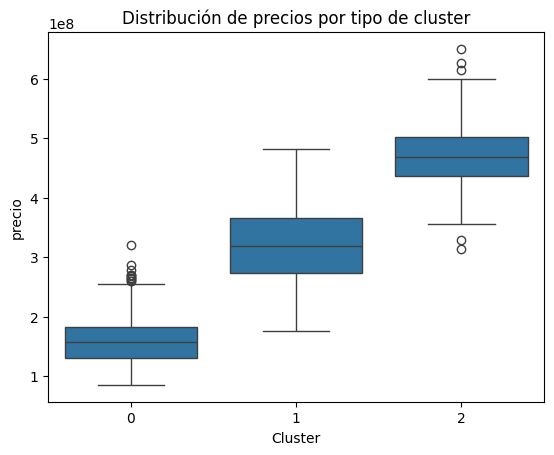

In [793]:
df['Cluster'] = mini_kmeans.labels_
sns.boxplot(x='Cluster', y='precio', data=df)
plt.title("Distribución de precios por tipo de cluster")
plt.show()

### Finalmente, comprobamos que el modelo distingue bastante bien la distribucion del precio segun el cluster, siendo el cluster 0 el nivel de lujo bajo.

## CLUSTERING FINAL (KMeans con 3 grupos)

In [794]:
kmeans = KMeans(n_clusters=3, random_state=42, n_init='auto')
final_labels = kmeans.fit_predict(X_pca)

df_Cluster = df.copy()
df_Cluster['Cluster'] = final_labels
df_Cluster.head()

,administración,estrato,antiguedad,área,habitaciones,baños,garajes,elevadores,tipo_de_inmueble,porteria,...,Localidad,Tasa_Homicidios_100k,Tasa_Hurtos_100k,incluye_remodelado,incluye_deposito,incluye_zona_de_lavanderia,incluye_gas,incluye_parqueadero,log_precio,Cluster
0,532000,4,37,86.0,1,1,1,1,Apartamento,24 hrs,...,CHAPINERO,5.2,1050.0,True,False,False,True,False,19.564585,1
1,0,6,7,77.0,1,2,2,1,Apartamento,24 hrs,...,USAQUEN,8.5,850.0,True,True,False,True,True,19.902513,1
2,811893,4,14,109.0,3,4,2,1,Apartamento,24 hrs,...,USAQUEN,8.5,850.0,True,False,False,True,True,20.020068,1
3,400200,4,11,76.0,3,2,1,2,Apartamento,24 hrs,...,SUBA,9.8,750.0,True,False,False,True,True,19.907499,1
4,270000,4,20,105.0,4,2,1,0,Casa,24 hrs,...,USAQUEN,8.5,850.0,True,True,False,True,True,19.773935,1


#### Notamos que las características de precio y área afectan el modelo en menor medida que la de tasa de hurtos y cantidad de garajes, asi que para considerarse lujo alto basta con obtener un area y precio promedio, pero al menos 1 garaje y una tasa baja de hurtos.

In [795]:
resumen = df_Cluster.groupby('Cluster')[['precio','área','Tasa_Hurtos_100k','garajes']].mean().sort_values(by='precio')
print("Promedios por grupo:")
print(resumen)

nombres = {resumen.index[0]: 'Bajo lujo', resumen.index[1]: 'Medio lujo', resumen.index[2]: 'Alto lujo'}
df_Cluster['nivel_lujo'] = df_Cluster['Cluster'].map(nombres)

Promedios por grupo:
               precio       área  Tasa_Hurtos_100k   garajes
Cluster                                                     
2        1.670827e+08  49.129032        731.881720  0.016129
0        1.772833e+08  48.858824        932.647059  0.082353
1        3.828366e+08  76.031532        823.333333  1.139640


#### Definimos las etiquetas de nuestra variable nivel de lujo como la media que resulta de la agrupación de la columna generada del cluster, con las características utilizadas en el modelo, ordenadas de forma ascendente por precio.

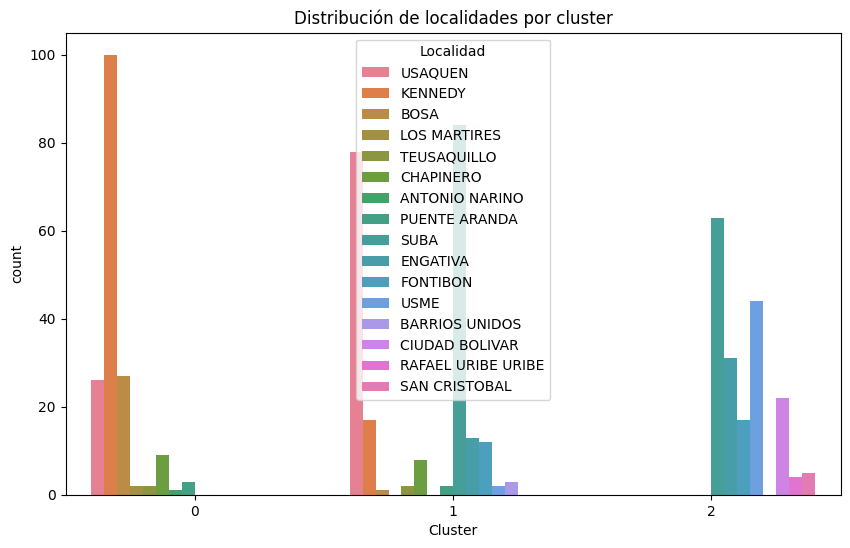

In [796]:
plt.figure(figsize=(10,6))
sns.countplot(data=df_Cluster, x='Cluster', hue='Localidad')
plt.title('Distribución de localidades por cluster')
plt.show()


#### Comprobamos que, en efecto, el nivel de lujo no solo se ve afectado por el precio y el área, sino tambien por la zona en la que se encuentre la propiedad.

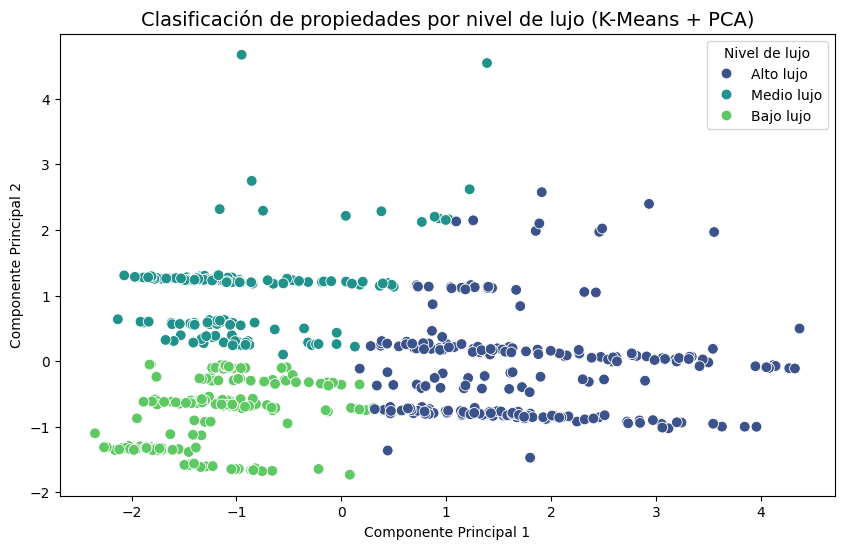

In [797]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=X_pca[:, 0], y=X_pca[:, 1],
    hue=df_Cluster['nivel_lujo'],
    palette='viridis', s=60
)
plt.title("Clasificación de propiedades por nivel de lujo (K-Means + PCA)", fontsize=14)
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.legend(title="Nivel de lujo")
plt.show()

#### Gráfico de comprobación para ver cuánta informacion obtenemos por cada componente generado.

## CSV que resulta del modelado de clustering.

In [798]:
df_Cluster.to_csv('../data/df_cluster.csv',index=False)